DIVA

In [1]:
%matplotlib inline
import os
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import pearsonr, shapiro, anderson
from scipy.spatial import ConvexHull

colors_ = ['firebrick', 'darkgreen', 'navy',  'deepskyblue', 'm','goldenrod', 'black', 'grey']

from exploration.data.data import load_sim_h5
from results_utils import *

In [2]:
def create_dict(groups_k):
    return {k[0] + '&' + k[1]: [] for k in groups_k}

def incremental_mean(arr_):
    n_samples = len(arr_)
    sum_ = 0
    out = []
    for i in range(n_samples):
        sum_ += arr_[i]
        out += [sum_/(i + 1.)]
    out = np.array(out).flatten()
    return out

def moving_av(arr_, win_sz):
    n_samples = len(arr_)
    sum_ = 0
    out = []
    for i in range(win_sz):
        sum_ += arr_[i]
        out += [sum_/(i + 1.)]
    for i in range(win_sz,n_samples):
        sum_ = sum_ + arr_[i] - arr_[i-win_sz]
        out += [sum_/win_sz]
    out = np.array(out).flatten()
    return out

def std_markers(ax,y,m,sz,color='b'):
    plt.sca(ax)
    for i,(y_,ms_) in enumerate(zip(y,sz)):
        plt.plot(i, y_, marker = m, ms = ms_, color = color)
        
def get_stat_test(dict_):
    thresh = []
    values  = []
    for key in dict_.keys():
        if 'autonomous' in key:
            continue
        values += [dict_[key]]
        key = key.split('&')
        key[0] = key[0].replace('_','.')
        thresh += [float(key[0])]

    return pearsonr(thresh, values)

In [5]:
directory = 'diva_IEEE_SI/experiment_IEEE_SI_slopes_cmf_323/'
data_files = os.listdir(directory)

n_samples = 102000
# Group by:
alpha_social_thresh = ['1_0', '0_999999', '0_99', '0_96', '0_93']
mode_ops = ['social']

groups1 = itertools.product(alpha_social_thresh, mode_ops)
groups2 = itertools.product(['1'], ['autonomous'])

groups_k =  list(groups2) + list(groups1)

#container for error
means_e = create_dict(groups_k)
means_av_e = create_dict(groups_k)

#container for social error
means_s = create_dict(groups_k)
means_av_s = create_dict(groups_k)
means_std_s = create_dict(groups_k)

#container for whole evaluation error 
means_w = create_dict(groups_k)
means_av_w = create_dict(groups_k)
means_std_w = create_dict(groups_k)

#container for convex hulls
ch_ = create_dict(groups_k)
ch_av = create_dict(groups_k)
ch_std = create_dict(groups_k)

#container for interactions social eval
means_inter_s = create_dict(groups_k)
means_inter_av_s = create_dict(groups_k)
stds_inter_av_s = create_dict(groups_k)

#container for interactions whole eval
means_inter_w = create_dict(groups_k)
means_inter_av_w = create_dict(groups_k)
stds_inter_av_w = create_dict(groups_k)

#container for acomulated collisions
coll_e = create_dict(groups_k)
coll_av_e = create_dict(groups_k)

#container for collisions in social evaluation (not used)
coll_s = create_dict(groups_k)
coll_av_s = create_dict(groups_k)
coll_std_s = create_dict(groups_k)

#container for collisions in whole evaluation (not used)
coll_w = create_dict(groups_k)
coll_av_w = create_dict(groups_k)
coll_std_w = create_dict(groups_k)

#container for interactions data 
inter = create_dict(groups_k)
inter_av = create_dict(groups_k)
inter_std = create_dict(groups_k)

inter_evo = create_dict(groups_k)
inter_evo_av = create_dict(groups_k)

#container for errors
error_ev = create_dict(groups_k)
error_ev_av = create_dict(groups_k)

#container for standar deviations
std_ev = create_dict(groups_k)

#container for competence during exploration
comp_w = create_dict(groups_k)
comp_av_w = create_dict(groups_k)

for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):
    data_file = directory + data_file
    conf_file = data_file.replace('sim_data.h5', 'conf.txt')
    conf = {}
    with open(conf_file) as f:
        for line in f:
            line = line.replace('\n', '')
            line = line.replace('\r', '')
            (key, val) = line.split(': ')
            conf[key] = val

    #try:
    #    if conf['instructor_slope']=='0.995':
    #        pass
    #except:
    #    conf['instructor_slope']='0.995'
    
    try:
        data,foo = load_sim_h5(data_file)
        interaction_data = data.social.data.as_matrix(columns=None)
        interactions = np.zeros((n_samples,))
        interactions[~np.isnan(interaction_data[:n_samples, 0])] = 1.

        social_data, foo = load_sim_h5(data_file.replace('sim_data.h5', 'sensor_eva_valset.h5'))
        
        s_error_ = np.linalg.norm(social_data.sensor_goal.data.as_matrix() -
                                  social_data.sensor.data.as_matrix(), axis=1)
        
        s_con_v = social_data.cons.data.as_matrix()
    
        e_con_v = data.cons.data.as_matrix()
        
        error_ = np.linalg.norm(data.sensor_goal.data.as_matrix() -
                                          data.sensor.data.as_matrix(), axis=1)

        error_ss_ = np.linalg.norm(data.somato_goal.data.as_matrix() -
                                  data.somato.data.as_matrix(), axis=1)


        eva_errors = []
        with open(data_file.replace('sim_data.h5', 'eval_error.txt'), 'r') as f:
            for line in f:
                line.replace('\n', '')
                eva_errors_str = line.split(': ')
                eva_errors += [float(eva_errors_str[1])]
                
        if conf['mode'] == 'autonomous':
            conf['instructor_slope'] = '1'
        else:
            conf['instructor_slope'] = conf['instructor_slope'].replace('.','_')
            
        means_s[conf['instructor_slope'] + '&' + conf['mode']] += [np.mean(s_error_)]
 
        coll_s[conf['instructor_slope'] + '&' + conf['mode']] += [np.mean(s_con_v)]
        coll_e[conf['instructor_slope'] + '&' + conf['mode']] += [e_con_v[:n_samples]]
        
        # ch_[conf['instructor_slope'] + '&' + conf['mode']] += [ConvexHull(data.sensor.data.as_matrix(),qhull_options='Q12').volume]
#         data = np.array(mat.get('SMdata'))
#         hull = ConvexHull(np.transpose(sensor_data))

#         hull_volumes[directory]=hull.volume
        
    
        inter[conf['instructor_slope'] + '&' + conf['mode']] += [np.sum(interactions)/float(n_samples)]
        
        inter_evo[conf['instructor_slope'] + '&' + conf['mode']] += [interactions]

        error_ev[conf['instructor_slope'] + '&' + conf['mode']] += [eva_errors]

        comp_w[conf['instructor_slope'] + '&' + conf['mode']] += [error_[:n_samples]]
        #wh_comp_w[conf['instructor_slope'] + '&' + conf['mode']] += [error_ss_[:2200]]  
        
    except IOError:
        print("Something went wrong!")

legend = []
max_std = 0
for i, k in enumerate(groups_k):
    print(k)
    group = k[0] + '&' + k[1] 
    legend += [group]

    means_av_s[group] = np.mean(np.array(means_s[group]))
    means_std_s[group] = np.std(np.array(means_s[group]))
    
    ch_av[group] = np.mean(np.array(ch_[group]))
    ch_std[group] = np.std(np.array(ch_[group]))
    
    coll_av_e[group] = np.mean(np.array(coll_e[group]), axis=0)
    coll_av_s[group] = np.mean(np.array(coll_s[group]), axis=0)
    coll_std_s[group] = np.std(np.array(coll_s[group]), axis=0)
    
    inter_av[group] = np.mean(np.array(inter[group]), axis=0)
    inter_std[group] = np.std(np.array(inter[group]), axis=0)
    
    inter_evo_av[group] = np.mean(np.array(inter_evo[group]), axis=0)
    
    comp_av_w[group] = np.mean(np.array(comp_w[group]), axis=0)
    #wh_comp_av_w[group] = np.mean(np.array(wh_comp_w[group]), axis=0)
    
    error_ev_av[group] = np.mean(np.array(error_ev[group]), axis=0)
    std_ev[group] = np.std(np.array(error_ev[group]),axis=0)
    max_std = max(max_std,max(std_ev[group].flatten()))
    
    
print(max_std)

('1', 'autonomous')
('1_0', 'social')
('0_999999', 'social')
('0_99', 'social')
('0_96', 'social')
('0_93', 'social')
0.38007362017497676


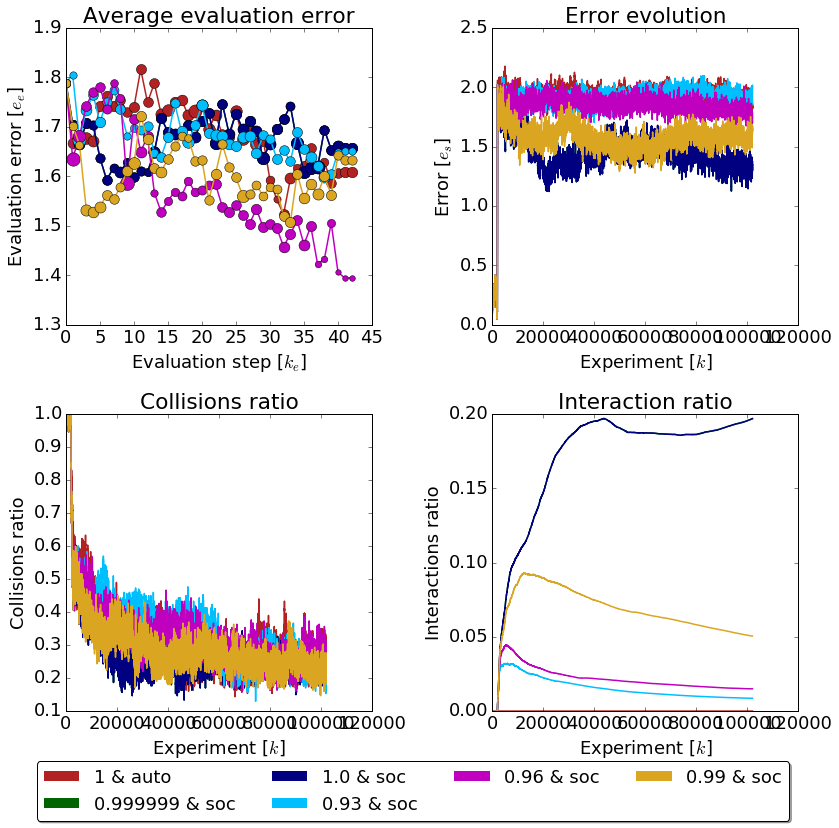

In [8]:
thresh_to_plot =  ['1_0&', '0_999999&','0_99&', '0_96&', '0_93&'] #['1_0&', '0_999999&','0_99&', '0_96&', '0_93&']
mode_to_plot = ['social']

custom = ['1&autonomous']

groups_to_plot = []
groups_to_plot_ = list(itertools.product(thresh_to_plot, mode_to_plot))
for group in groups_to_plot_:
    groups_to_plot += [group[0]+group[1]]
groups_to_plot = groups_to_plot + custom

matplotlib.rcParams['figure.figsize'] = (12.0, 11.0)
matplotlib.rcParams.update({'font.size': 18})

fig1, ax1 = plt.subplots(2,2)
plt.sca(ax1[0,0])
ax1[0,0].set_title('Average evaluation error')
for key, color in zip(error_ev_av.keys(), colors_):
    try:
        if key not in groups_to_plot:
            continue
        data_plt = error_ev_av[key]
        plt.plot(data_plt, linestyle='-', marker='',lw = 1.5, color=color)
        ms = [(x/max_std)*13 + 1 for x in std_ev[key]]
        std_markers(ax1[0,0],error_ev_av[key],'o',ms,color=color)
    except:
        continue
plt.xlabel('Evaluation step [$k_e$]')
plt.ylabel('Evaluation error [$e_e$]')
# ax1[0,1].set_xlim([200,n_samples])
# ax1[0,1].set_ylim([0,0.25])

plt.sca(ax1[0,1])
ax1[0,1].set_title('Error evolution')
win_sz=50
for key, color in zip(error_ev_av.keys(), colors_):
    try:
        if key not in groups_to_plot:
            continue
        data_plt = moving_av(comp_av_w[key],win_sz)
        plt.plot(data_plt, linestyle='-', marker='', lw = 1.5, color=color)
    except:
        continue
plt.xlabel('Experiment [$k$]')
plt.ylabel('Error [$e_s$]')
# ax1[0,1].set_xlim([200,n_samples])
# ax1[0,1].set_ylim([0,0.25])


plt.sca(ax1[1,0])
ax1[1,0].set_title('Collisions ratio')
for key, color in zip(error_ev_av.keys(), colors_):
    try:
        if key not in groups_to_plot:
            continue
        data_plt = moving_av(coll_av_e[key],win_sz)
        plt.plot(data_plt, linestyle='-', marker='',lw = 1.5,color=color)
    except:
        continue
plt.xlabel('Experiment [$k$]')
plt.ylabel('Collisions ratio')
# ax1[1,0].set_xlim([0,n_samples])
# ax1[1,0].set_ylim([0,0.8])

plt.sca(ax1[1,1])
ax1[1,1].set_title('Interaction ratio')
for key, color in zip(error_ev_av.keys(), colors_):
    try:
        data_plt = incremental_mean(inter_evo_av[key])
        plt.plot(data_plt, linestyle='-', marker='',lw = 1.5,color=color)
    except:
        continue
plt.xlabel('Experiment [$k$]')
plt.ylabel('Interactions ratio')
# ax1[1,1].set_xlim([0,n_samples])
# ax1[1,1].set_ylim([0,0.08])

lds_ = []
for key, color in zip(error_ev_av.keys(), colors_):
    key = key.replace('_','.')
    key = key.replace('&',' & ')
    key = key.replace('social','soc')
    key = key.replace('autonomous','auto')
    lds_ += [key]

lgd = plt.legend(lds_,\
           ncol=4,loc='lower right', fontsize=18, bbox_to_anchor=(1., -0.4),
          fancybox=True, shadow=True)
for legobj in lgd.legendHandles:
    legobj.set_linewidth(10.0)


plt.tight_layout()

# fig1.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/IEEE_TCDS_Special_Issue/images/parabola_results.eps',\
#              format='eps', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [59]:
print(get_stat_test(means_av_s))
print(get_stat_test(means_std_s))

(0.95038932802555742, 0.013165520284096248)
(0.66128436533918977, 0.22422634720753401)


In [120]:
means_av_s

{'0_93&social': 1.4911744858212537,
 '0_96&social': 1.5674740206605637,
 '0_99&social': 1.4724122746868591,
 '0_999999&social': 1.513965512047359,
 '1&autonomous': 1.6195778244262151,
 '1_0&social': 1.513965512047359}

In [26]:
coll_av_s

{'0_93&social': 0.79721362229102166,
 '0_96&social': 0.73013415892672862,
 '0_99&social': 0.79824561403508776,
 '0_999999&social': 0.80340557275541791,
 '1&autonomous': 0.77708978328173384,
 '1_0&social': 0.80340557275541791}

In [27]:
inter_av

{'0_93&social': 0.0085816993464052273,
 '0_96&social': 0.014975490196078431,
 '0_99&social': 0.050491830065359476,
 '0_999999&social': 0.19703104575163399,
 '1&autonomous': 0.0,
 '1_0&social': 0.19703104575163397}

In [32]:
# fig1.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/IEEE_TCDS_Special_Issue/images/diva_results.eps',\
#              format='eps', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')

fig1.savefig('diva_results_323.eps',format='eps', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
fig1.savefig('diva_results_323.png',format='png', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
# Processing slow descriptors

#container for convex hulls
ch_ = create_dict(groups_k)
ch_av = create_dict(groups_k)
ch_std = create_dict(groups_k)

#container for unarticulated productions
means_unart_s = create_dict(groups_k)
means_unart_av_s = create_dict(groups_k)
stds_unar_s = create_dict(groups_k)

#container for coarticulated productions
means_coart_s = create_dict(groups_k)
means_coart_av_s = create_dict(groups_k)
stds_coar_s = create_dict(groups_k)

continue__ = True   #To skip corrupt simulation with 123
for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):
#     print "Trying"
    data_file = directory + data_file
    conf_file = data_file.replace('sim_data.h5', 'conf.txt')
    conf = {}
    with open(conf_file) as f:
        for line in f:
            line = line.replace('\n', '')
            line = line.replace('\r', '')
            (key, val) = line.split(': ')
            conf[key] = val
    if conf['mode'] == 'autonomous':
        conf['instructor_slope'] = '1'
    else:
        conf['instructor_slope'] = conf['instructor_slope'].replace('.','_')
    key = conf['instructor_slope'] + '&' + conf['mode']
    if key not in groups_to_plot:
#         print "Not here"
        continue
    if not continue__:
        continue__ = True
        continue
#     print "Still trying"

    try:
        print key
        data,foo = load_sim_h5(data_file)
        sensor_data = data.sensor.data.as_matrix(columns=None)
                
        ch_[conf['instructor_slope'] + '&' + conf['mode']] += [ConvexHull(data.sensor.data.as_matrix(),qhull_options='Q12').volume]
        means_unart_s[conf['instructor_slope'] + '&' + conf['mode']] += [float(np.where(np.logical_xor(sensor_data[:,2]>0.1, sensor_data[:,5]>0.1))[0].shape[0])/float(n_samples)]
        means_coart_s[conf['instructor_slope'] + '&' + conf['mode']] += [float(np.where(np.logical_and(sensor_data[:,2]>0.1, sensor_data[:,5]>0.1))[0].shape[0])/float(n_samples)]

    except IOError:
        print("Something went terribly wrong!")

In [122]:
legend = []
max_std = 0
for i, group in enumerate(groups_to_plot):
    legend += [group]

    ch_av[group] = np.mean(np.array(ch_[group]))
    ch_std[group] = np.std(np.array(ch_[group]))
    
    means_unart_av_s[group] = np.mean(np.array(means_unart_s[group]))
    stds_unar_s[group] = np.std(np.array(means_unart_s[group]))

    means_coart_av_s[group] = np.mean(np.array(means_coart_s[group]))
    stds_coar_s[group] = np.std(np.array(means_coart_s[group]))

In [123]:
ch_av

{'0_93&social': [],
 '0_96&social': [],
 '0_99&social': [],
 '0_999999&social': [],
 '1&autonomous': [],
 '1_0&social': []}

In [124]:
means_unart_av_s

{'0_93&social': [],
 '0_96&social': [],
 '0_99&social': 0.41542647058823529,
 '0_999999&social': [],
 '1&autonomous': 0.57748366013071906,
 '1_0&social': []}

In [125]:
means_coart_av_s

{'0_93&social': [],
 '0_96&social': [],
 '0_99&social': 0.32349836601307186,
 '0_999999&social': [],
 '1&autonomous': 0.097390522875816996,
 '1_0&social': []}

In [32]:
# float(np.where(np.logical_xor(sensor_data[:,2]>0.1, sensor_data[:,5]>0.1))[0].shape[0])/float(n_samples)
# float(np.where(np.logical_and(sensor_data[:,2]>0.1, sensor_data[:,5]>0.1))[0].shape[0])/float(n_samples)

0.5218627450980392

0_99&social
0_99&social
0_99&social
0_99&social
0_99&social
0_99&social
0_99&social


(0, 1.01)

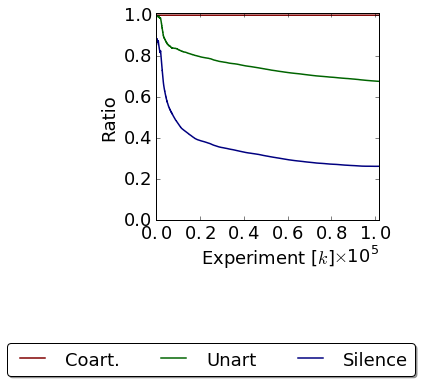

In [118]:
thresh_to_plot =  ['0_99&'] #['1_0&', '0_999999&','0_99&', '0_96&', '0_93&']
mode_to_plot = ['social']

custom = [] #['1&autonomous']

groups_to_plot = []
groups_to_plot_ = list(itertools.product(thresh_to_plot, mode_to_plot))
for group in groups_to_plot_:
    groups_to_plot += [group[0]+group[1]]
groups_to_plot = groups_to_plot + custom
# Processing slow descriptors

#container for unarticulated productions
means_unart_s = create_dict(groups_k)
means_unart_av = create_dict(groups_k)

#container for coarticulated productions
means_coart_s = create_dict(groups_k)
means_coart_av = create_dict(groups_k)

continue__ = True
for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):
#     print "Trying"
    data_file = directory + data_file
    conf_file = data_file.replace('sim_data.h5', 'conf.txt')
    conf = {}
    with open(conf_file) as f:
        for line in f:
            line = line.replace('\n', '')
            line = line.replace('\r', '')
            (key, val) = line.split(': ')
            conf[key] = val
    if conf['mode'] == 'autonomous':
        conf['instructor_slope'] = '1'
    else:
        conf['instructor_slope'] = conf['instructor_slope'].replace('.','_')
    key = conf['instructor_slope'] + '&' + conf['mode']
    if key not in groups_to_plot:
#         print "Not here"
        continue
    if not continue__:
        continue__ = True
        continue
#     print "Still trying"

    try:
        print key
        data,foo = load_sim_h5(data_file)
        sensor_data = data.sensor.data.as_matrix(columns=None)
                
        means_unart_s[conf['instructor_slope'] + '&' + conf['mode']] += [(np.logical_xor(sensor_data[:,2]>0.1, sensor_data[:,5]>0.1)).astype(np.float)[:n_samples]]
        means_coart_s[conf['instructor_slope'] + '&' + conf['mode']] += [(np.logical_and(sensor_data[:,2]>0.1, sensor_data[:,5]>0.1)).astype(np.float)[:n_samples]]

    except IOError:
        print("Something went terribly wrong!")
        
xfmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
xfmt.set_powerlimits((-3,3))

matplotlib.rcParams['figure.figsize'] = (4.0, 3.7)
matplotlib.rcParams.update({'font.size': 18})

fig, axes = plt.subplots()
for key, color in zip(groups_to_plot, colors_):
    try:
        print key
        means_unart_av[key] = np.mean(np.array(means_unart_s[key]), axis=0)
        means_coart_av[key] = np.mean(np.array(means_coart_s[key]), axis=0)
        
        data_plt_coart = incremental_mean(means_coart_av[key])
        data_plt_unart = incremental_mean(means_unart_av[key])
        data_plt_silence  = np.array([1-x for x in np.add(data_plt_coart,data_plt_unart)])
        
#         data_plt_unart = np.add(data_plt_coart,data_plt_unart)
#         data_plt_silence = np.add(data_plt_silence,data_plt_unart)

        data_plt_unart = np.add(data_plt_silence,data_plt_unart)
        data_plt_coart = np.add(data_plt_coart,data_plt_unart)
    
        plt.plot(data_plt_coart, linestyle='-', marker='',lw = 1.5,color='maroon')
        plt.plot(data_plt_unart, linestyle='-', marker='',lw = 1.5,color='darkgreen')
        plt.plot(data_plt_silence, linestyle='-', marker='',lw = 1.5,color='navy')
        
    except:
        print 'Wrong'
        continue

lgd = plt.legend(['Coart.', 'Unart', 'Silence'],\
           ncol=3,loc='lower right', fontsize=18, bbox_to_anchor=(1.2, -0.8),
          fancybox=True, shadow=True)
plt.gca().xaxis.set_major_formatter(xfmt)
plt.xlabel('Experiment [$k$]')
plt.ylabel('Ratio')
axes.set_xlim([0,n_samples])
axes.set_ylim([0,1.01])

In [116]:
fig.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/IEEE_TCDS_Special_Issue/images/legends.eps',\
             format='eps', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')